In [88]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob

In [102]:
original_address = '/scratch/student/shokoofa/'

In [103]:
train_path = set(i.split('/')[-2] for i in glob.glob(os.path.join(original_address + '/dataset/Train/*', '*')))
valid_path = set(i.split('/')[-2] for i in glob.glob(os.path.join(original_address + '/dataset/Valid/*', '*')) )
test_path = set( i.split('/')[-2] for i in glob.glob(os.path.join(original_address + '/dataset/Test/*', '*')) )

In [104]:
info = pd.read_csv(os.path.join(original_address , 'labels_file.csv'))

In [105]:
info['sample_path'] = info['sample_path'].astype(str)
info['path'] = info['sample_path'].apply(lambda x: '/'.join(x.split(' ')[:2]))
label_path = info['path'].values
data_labels = info['label'].values

In [106]:
image_train_path = []
image_test_path = []
image_val_path = []

label_train_path = []
label_test_path = []
label_val_path = []

for i,sub_folder in enumerate(label_path):
    if sub_folder.split('/')[0] in train_path:
        label_train_path.append(data_labels[i])
        image_train_path.append('Train/' + sub_folder)
    elif sub_folder.split('/')[0] in valid_path:
        label_val_path.append(data_labels[i])
        image_val_path.append('Valid/' + sub_folder)
    else:
        label_test_path.append(data_labels[i])
        image_test_path.append('Test/' + sub_folder)

In [107]:
train_df = pd.DataFrame({'path': image_train_path, 'label': label_train_path})
val_df = pd.DataFrame({'path': image_val_path, 'label': label_val_path})
test_df = pd.DataFrame({'path': image_test_path, 'label': label_test_path})

In [84]:
train_df.to_csv('train_labels_original.csv', index=False)
val_df.to_csv('val_labels_original.csv', index=False)
test_df.to_csv('test_labels_original.csv', index=False)

In [108]:
train_df

,path,label
0,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch
1,Train/6fwt32TiT_KD-QU8t64_eg/46,Apical-4ch
2,Train/6fwt32TiT_KD-QU8t64_eg/47,Apical-4ch
3,Train/6fwt32TiT_KD-QU8t64_eg/83,Subcostal
4,Train/6fwt32TiT_KD-QU8t64_eg/62,Apical-2ch
...,...,...
2492,Train/0oMWy6kqR0edXPJd8BbxYg/8,PLAX
2493,Train/0oMWy6kqR0edXPJd8BbxYg/57,Apical-3ch
2494,Train/0oMWy6kqR0edXPJd8BbxYg/33,Apical-4ch
2495,Train/0oMWy6kqR0edXPJd8BbxYg/74,Subcostal


In [86]:
test_df

,path,label
0,Test/_sGIp1RTSrGCz_CBPrfU3g/21,Subcostal
1,Test/_sGIp1RTSrGCz_CBPrfU3g/46,PSAX-base
2,Test/_sGIp1RTSrGCz_CBPrfU3g/11,Subcostal
3,Test/_sGIp1RTSrGCz_CBPrfU3g/47,PSAX-mid
4,Test/_sGIp1RTSrGCz_CBPrfU3g/75,Apical-3ch
...,...,...
234,Test/3nRPNSozRYSJy2tmnGdyzg/37,Apical-4ch
235,Test/3nRPNSozRYSJy2tmnGdyzg/81,Subcostal
236,Test/3nRPNSozRYSJy2tmnGdyzg/5,PLAX
237,Test/3nRPNSozRYSJy2tmnGdyzg/19,PSAX-ves


In [109]:
def creating_new_df(image_list, label_list, dict, window_size = 16, window_slide = 2):
    for idx in range(len(image_list)):
        frames_per_sample = []
        for item in glob.glob(os.path.join(original_address + '/dataset/' + image_list[idx] + '/', '*')):
            frames_per_sample.append(int(item.split('_')[-1].replace('.jpeg', '')))
        frames_per_sample = sorted(frames_per_sample)
        length = frames_per_sample[-1] - frames_per_sample[0]
        i = 0
        ls = []
        while (i+ window_size <= length):
            ls.append([*range(frames_per_sample[i], frames_per_sample[i + window_size])])
            i += window_slide
        for num_sub_videos in range(len(ls)):
            dict['path'].append('/'.join(item.split('/')[-4:-1])) 
            dict['label'].append(label_list[idx])
            dict['start'].append(ls[num_sub_videos][0])
            dict['end'].append(ls[num_sub_videos][-1])
    new_df = pd.DataFrame(dict)
    return(new_df)

In [ ]:
# ### for big general datast 
# def creating_new_df(image_list, label_list, dict, window_size = 16, window_slide = 2):
#     for idx in range(len(image_list)):
#         frames_per_sample = []
#         for item in glob.glob(os.path.join(original_address + '/dataset/' + image_list[idx] + '/', '*')):
#             frames_per_sample.append(int(item.split('_')[-1].replace('.jpeg', '')))
#         frames_per_sample = sorted(frames_per_sample)
#         length = frames_per_sample[-1] - frames_per_sample[0]
#         i = 0
#         ls = []
#         while (i+ window_size <= length):
#             ls.append([*range(frames_per_sample[i], frames_per_sample[i + window_size])])
#             i += window_slide
#         for num_sub_videos in range(len(ls)):
#             dict['path'].append('/'.join(item.split('/')[-3:-1])) 
#             dict['label'].append(label_list[idx])
#             dict['start'].append(ls[num_sub_videos][0])
#             dict['end'].append(ls[num_sub_videos][-1])
#     new_df = pd.DataFrame(dict)
#     return(new_df)

In [112]:
dict = {'path':[], 'label':[], 'start': [], 'end': []}
window_size = 16
window_slide = 2
new_train_df = creating_new_df(image_train_path, label_train_path, dict )
dict = {'path':[], 'label':[], 'start': [], 'end': []}
new_val_df = creating_new_df(image_val_path, label_val_path, dict )
dict = {'path':[], 'label':[], 'start': [], 'end': []}
new_test_df = creating_new_df(image_test_path, label_test_path, dict )

In [113]:
new_train_df

,path,label,start,end
0,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch,2,17
1,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch,4,19
2,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch,6,21
3,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch,8,23
4,Train/6fwt32TiT_KD-QU8t64_eg/65,Apical-3ch,10,25
...,...,...,...,...
29358,Train/0oMWy6kqR0edXPJd8BbxYg/29,PSAX-mid,18,33
29359,Train/0oMWy6kqR0edXPJd8BbxYg/29,PSAX-mid,20,35
29360,Train/0oMWy6kqR0edXPJd8BbxYg/29,PSAX-mid,22,37
29361,Train/0oMWy6kqR0edXPJd8BbxYg/29,PSAX-mid,24,39


In [76]:
# # ### for big general datast 
# df_final = pd.concat([new_train_df, new_val_df, new_test_df], axis = 0)
# df_final.to_csv('final_large_labels.csv', index= False)

In [114]:
new_train_df.to_csv('train_labels_sw16.csv', index=False)
new_val_df.to_csv('val_labels_sw16.csv', index=False)
new_test_df.to_csv('test_labels_sw16.csv', index=False)

### Stratify train and val

In [90]:
info = pd.read_csv(os.path.join(original_address , 'labels_file.csv'))
test = pd.read_csv(os.path.join(original_address, 'test_labels_original.csv'))

In [91]:
info

,RPeak1,RPeak2,sample_path,frame_size,potential_frame_size,label
0,2,28,6fwt32TiT_KD-QU8t64_eg 65,26,23,Apical-3ch
1,1,40,6fwt32TiT_KD-QU8t64_eg 46,39,36,Apical-4ch
2,1,23,6fwt32TiT_KD-QU8t64_eg 47,22,23,Apical-4ch
3,3,21,6fwt32TiT_KD-QU8t64_eg 83,18,23,Subcostal
4,27,70,6fwt32TiT_KD-QU8t64_eg 62,43,47,Apical-2ch
...,...,...,...,...,...,...
2988,3,39,0oMWy6kqR0edXPJd8BbxYg 8,36,36,PLAX
2989,2,32,0oMWy6kqR0edXPJd8BbxYg 57,30,23,Apical-3ch
2990,1,14,0oMWy6kqR0edXPJd8BbxYg 33,13,12,Apical-4ch
2991,1,31,0oMWy6kqR0edXPJd8BbxYg 74,30,23,Subcostal


In [92]:
ls = []
for item in test['path']:
    ls.append(' '.join(item.split('/')[1:]))
for i, row in enumerate(info.iterrows()):
    if row[1][2] in ls:
        info.drop(i , axis=0, inplace=True)

In [93]:
info

,RPeak1,RPeak2,sample_path,frame_size,potential_frame_size,label
0,2,28,6fwt32TiT_KD-QU8t64_eg 65,26,23,Apical-3ch
1,1,40,6fwt32TiT_KD-QU8t64_eg 46,39,36,Apical-4ch
2,1,23,6fwt32TiT_KD-QU8t64_eg 47,22,23,Apical-4ch
3,3,21,6fwt32TiT_KD-QU8t64_eg 83,18,23,Subcostal
4,27,70,6fwt32TiT_KD-QU8t64_eg 62,43,47,Apical-2ch
...,...,...,...,...,...,...
2988,3,39,0oMWy6kqR0edXPJd8BbxYg 8,36,36,PLAX
2989,2,32,0oMWy6kqR0edXPJd8BbxYg 57,30,23,Apical-3ch
2990,1,14,0oMWy6kqR0edXPJd8BbxYg 33,13,12,Apical-4ch
2991,1,31,0oMWy6kqR0edXPJd8BbxYg 74,30,23,Subcostal


In [94]:
from sklearn.model_selection import train_test_split

train_data_part, val_data_part = train_test_split(info, test_size=0.1, stratify=info['label'], random_state=42)

train_data_part = train_data_part.reset_index(drop=True)
val_data_part = val_data_part.reset_index(drop=True)

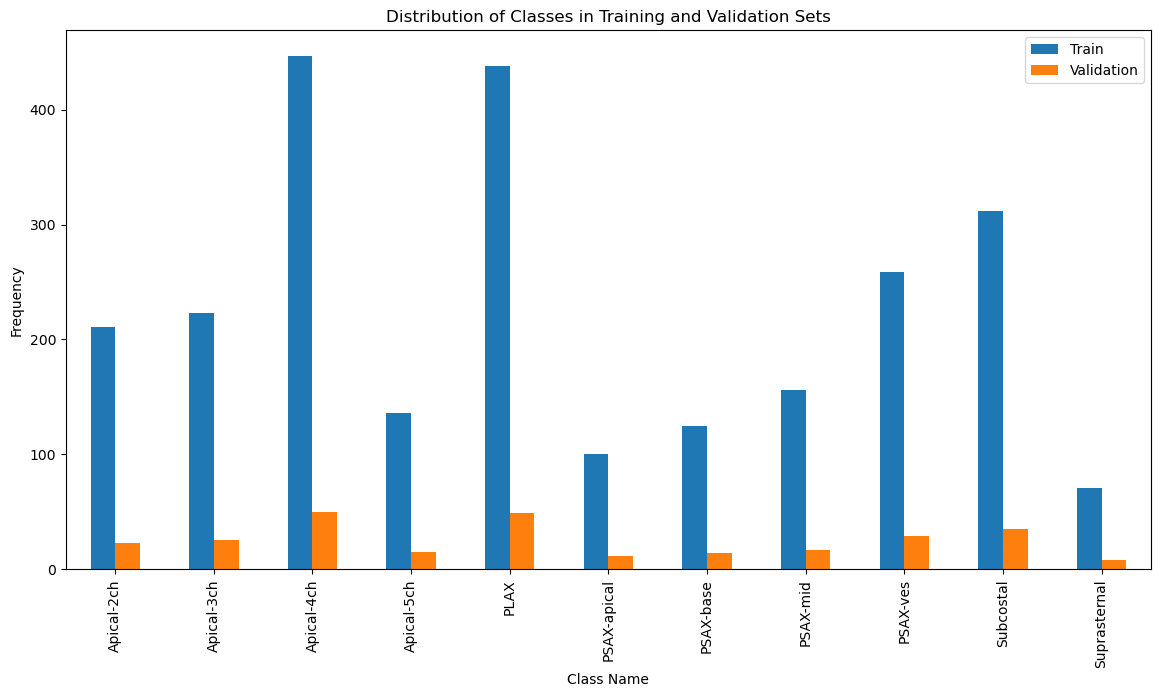

In [96]:
train_dict = train_data_part['label'].value_counts().to_dict()
val_dict =val_data_part['label'].value_counts().to_dict()

all_classes = set(train_dict.keys()).union(set(val_dict.keys()))
train_dict_full = {cls: train_dict.get(cls, 0) for cls in all_classes}
val_dict_full = {cls: val_dict.get(cls, 0) for cls in all_classes}

df_counts = pd.DataFrame({'Train': train_dict_full, 'Validation': val_dict_full})

df_counts = df_counts.sort_index()

# df_counts = pd.DataFrame({'Train': train_counts, 'Validation': val_counts})

# Plot
ax = df_counts.plot(kind='bar', figsize=(14, 7))
ax.set_xlabel("Class Name")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Classes in Training and Validation Sets")

# Show the plot
plt.show()

In [101]:
ls = []

for item in train_data_part['sample_path']:
    ls.append(item.split(' ')[0])

for i, row in enumerate(val_data_part.iterrows()):
    if row[1][2].split(' ')[0] in ls:
        print(row[1][2])

5sQAnY9VSsiUE7h_lWCLSA 31
-f0SMS6_Thmdc9gB6ikhYA 18
3-1wHgLZTc-UOvkFMUFVHg 21
-8UKHE9bQ0u09nleXrwgBg 42
-y5n3TddSIyFathZfDyD_g 3
_wlw5E-pSJOQB_wb-vCVEA 36
_97o_EX3QmG2aMY69frzeg 81
1Sq9hUECQ5yCzjgDzCK2Fw 48
2-UTAHVDTiWhVn9BoQrlOQ 75
4S0Vw_-kQ2C6VUQfjBPWNg 28
_IF5AJccSU6twToozlWXeQ 74
5k3e47wYSzO-hDHX1wY7pA 73
3c484NwiQDq35JlQVPLq4g 82
-40uXj7VSHK4KVuHfAjiYQ 67
-Lfio4cmRuiiQ2TgfNKtAg 10
4g9UZXZrQG6E35BSL7EDRA 45
0oMWy6kqR0edXPJd8BbxYg 8
05kiNilER5SfMea2fZtv4A 36
-OrRL-k0S4qeKxUGhHZuVA 109
1YcCzf5PQQqZludDW3sIug 84
0z_nygOVSnu6m1BPUeKYGA 19
5z2VhLzqQS-y26p74pg0BA 34
5z2VhLzqQS-y26p74pg0BA 5
-y5n3TddSIyFathZfDyD_g 2
_AUUJEOXSs2WoII-wfCA9w 28
_9ecEo6FQYGXpjlFdZ64hw 85
_3wRyUbdSGmjEWULRVg-jw 43
0xygCXzTTlWW6trecOGS_A 13
-Lfio4cmRuiiQ2TgfNKtAg 66
4g9UZXZrQG6E35BSL7EDRA 6
2TAP1rPJRuuJA7BPSmmpig 133
6fwt32TiT_KD-QU8t64_eg 19
4-Cx24SORvCeeeUaelutMw 4
_IF5AJccSU6twToozlWXeQ 5
1FAWln61SReNMFQTpwJLaQ 33
_IF5AJccSU6twToozlWXeQ 69
-OrRL-k0S4qeKxUGhHZuVA 119
_fpOPq7mSyKI-q7AIVddew 4
0CB7JJJvQ4OUM0mXS

In [98]:
val_data_part

,RPeak1,RPeak2,sample_path,frame_size,potential_frame_size,label
0,2,44,5sQAnY9VSsiUE7h_lWCLSA 31,42,47,PSAX-apical
1,6,46,-f0SMS6_Thmdc9gB6ikhYA 18,40,36,PSAX-ves
2,1,28,3-1wHgLZTc-UOvkFMUFVHg 21,27,23,PSAX-ves
3,1,16,-8UKHE9bQ0u09nleXrwgBg 42,15,12,Apical-4ch
4,3,55,-y5n3TddSIyFathZfDyD_g 3,52,47,PLAX
...,...,...,...,...,...,...
271,1,23,-f0SMS6_Thmdc9gB6ikhYA 67,22,23,Subcostal
272,1,15,5orz-RcoStqoUuy0aTUZqA 6,14,12,PLAX
273,7,47,-f0SMS6_Thmdc9gB6ikhYA 26,40,36,PSAX-base
274,1,16,5Py758FpTQaUUn88p0z2ug 33,15,12,PSAX-base
